<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Question-1" data-toc-modified-id="Question-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Question 1</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Getting-the-Data" data-toc-modified-id="Getting-the-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Getting the Data</a></span></li></ul></li><li><span><a href="#Part-B" data-toc-modified-id="Part-B-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part B</a></span><ul class="toc-item"><li><span><a href="#i)-Using-previous-hidden-unit,-previous-character,-and-previous-category" data-toc-modified-id="i)-Using-previous-hidden-unit,-previous-character,-and-previous-category-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>i) Using previous hidden unit, previous character, and previous category</a></span><ul class="toc-item"><li><span><a href="#Model-Definition" data-toc-modified-id="Model-Definition-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Model Definition</a></span></li></ul></li><li><span><a href="#ii)-Using-previous-hidden-unit,-previous-character" data-toc-modified-id="ii)-Using-previous-hidden-unit,-previous-character-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ii) Using previous hidden unit, previous character</a></span></li><li><span><a href="#iii)-Using-previous-hidden-unit,-category" data-toc-modified-id="iii)-Using-previous-hidden-unit,-category-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>iii) Using previous hidden unit, category</a></span></li><li><span><a href="#iv)-Using-previous-hidden-unit" data-toc-modified-id="iv)-Using-previous-hidden-unit-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>iv) Using previous hidden unit</a></span></li><li><span><a href="#Comparing-Data-Fed-to-Hidden-Units" data-toc-modified-id="Comparing-Data-Fed-to-Hidden-Units-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Comparing Data Fed to Hidden Units</a></span></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li></ul></div>

# Question 1

## Imports

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random
import unicodedata
import string
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

## Getting the Data

In [2]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip -o data.zip

--2019-08-02 14:23:51--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.84.141.242, 52.84.141.182, 52.84.141.200, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.84.141.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  13.3MB/s    in 0.2s    

2019-08-02 14:23:51 (13.3 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/It

In [3]:
class DataLoader: 
    
    def __init__(self):
        
        all_letters = string.ascii_letters + " .,;'-"
        n_letters = len(all_letters) + 1 #  Plus EOS marker
        self.n_letters = n_letters
        self.all_letters = all_letters
        
        # Build the category_lines dictionary, a list of names per language
        category_lines = {}
        train_data = {}
        test_data = {}
        all_categories = []
        
        for filename in self.findFiles('data/names/*.txt'):
            category = os.path.splitext(os.path.basename(filename))[0]
            all_categories.append(category)
            lines = self.readLines(filename)
            random.shuffle(lines)
            train_data[category] = lines[0:int(math.floor(0.8*len(lines)))]
            test_data[category] = lines[int(math.floor(0.8*len(lines)))+1:]
            category_lines[category] = lines

        n_categories = len(all_categories)
        
        self.n_categories = n_categories
        self.train_data = train_data
        self.test_data = test_data
        self.all_categories = all_categories

            
    def findFiles(self, path):
        return glob.glob(path)
    
    # Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
    def unicodeToAscii(self, s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in self.all_letters
        )

    # Read a file and split into lines
    def readLines(self, filename):
        lines = open(filename, encoding='utf-8').read().strip().split('\n')
        return [self.unicodeToAscii(line) for line in lines]

    def randomChoice(self, l):
        return l[random.randint(0, len(l) - 1)]
    
    def randomTrainingPair(self):
        category = self.randomChoice(self.all_categories)
        line = self.randomChoice(self.train_data[category])
        return category, line
    
    def randomTrainingExample(self):
        category, line = self.randomTrainingPair()
        category_tensor = self.categoryTensor(category)
        input_line_tensor = self.inputTensor(line)
        target_line_tensor = self.targetTensor(line)
        return category_tensor, input_line_tensor, target_line_tensor
    
    # Find letter index from all_letters, e.g. "a" = 0
    def letterToIndex(self, letter):
        return self.all_letters.find(letter)
    
    # One-hot vector for category
    def categoryTensor(self, category):
        li = self.all_categories.index(category)
        tensor = torch.zeros(1, self.n_categories)
        tensor[0][li] = 1
        return tensor

    # One-hot matrix of first to last letters (not including EOS) for input
    def inputTensor(self, line):
        tensor = torch.zeros(len(line), 1, self.n_letters)
        for li in range(len(line)):
            letter = line[li]
            tensor[li][0][self.all_letters.find(letter)] = 1
        return tensor

    # LongTensor of second letter to end (EOS) for target
    def targetTensor(self, line):
        letter_indexes = [self.all_letters.find(line[li]) for li in range(1, len(line))]
        letter_indexes.append(self.n_letters - 1) # EOS
        return torch.LongTensor(letter_indexes)

DL = DataLoader()

# Part B

## i) Using previous hidden unit, previous character, and previous category

### Model Definition

In [18]:
class RNN_HCC(nn.Module):
    def __init__(self, hidden_size, DL=DL):
        super(RNN_HCC, self).__init__()
        self.hidden_size = hidden_size
        input_size = DL.n_letters
        output_size = DL.n_letters
        self.input_size = input_size
        self.output_size = output_size
        self.DL = DL

        self.i2h = nn.Linear(DL.n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(DL.n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.criterion = nn.NLLLoss()
        self.learning_rate = 0.0005
        self.max_length = 20

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def train_single(self, category_tensor, input_line_tensor, target_line_tensor):
        print(target_line_tensor)

        target_line_tensor.unsqueeze_(-1)
        hidden = self.initHidden()

        self.zero_grad()

        loss = 0
        print(target_line_tensor)
        for i in range(input_line_tensor.size(0)):
            output, hidden = self(category_tensor, input_line_tensor[i], hidden)
            print(output.shape)
            print(output)
            print(target_line_tensor[i].shape)
            print(target_line_tensor[i])

            l = self.criterion(output, target_line_tensor[i])
            loss += l

        loss.backward()

        for p in self.parameters():
            p.data.add_(-self.learning_rate, p.grad.data)

        return output, loss.item() / input_line_tensor.size(0)
    
    def evaluate(self, category_tensor, input_line_tensor, target_line_tensor):
        target_line_tensor.unsqueeze_(-1)
        hidden = self.initHidden()
        loss = 0
        for i in range(input_line_tensor.size()[0]):
            output, hidden = self(category_tensor, input_line_tensor[i], hidden)
            loss += self.criterion(output, target_line_tensor[i])
        return output, loss.item() / input_line_tensor.size(0)
    
    def timeSince(self,since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)
    
    def train(self):

        n_iters = 100000
        print_every = 5000
        plot_every = 500
        all_losses = []
        all_test_losses = []
        total_loss = 0 # Reset every plot_every iters

        start = time.time()

        for iter in range(1, n_iters + 1):
            output, loss = self.train_single(*self.DL.randomTrainingExample())
            total_loss += loss

            if iter % print_every == 0:
                print('%s (%d %d%%) %.4f' % (self.timeSince(start), iter, iter / n_iters * 100, loss))

            if iter % plot_every == 0:
                all_losses.append(total_loss / plot_every)
                total_loss = 0

            # Compute loss based on test data
            if iter % plot_every == 0:
                total_test_loss = 0
                n_test_instances = 0
                for category in self.DL.all_categories:
                    category_tensor = Variable(self.DL.categoryTensor(category))
                    n_test_instances = n_test_instances + len(self.DL.test_data[category])
                    for line in self.DL.test_data[category]:
                        input_line_tensor = Variable(self.DL.inputTensor(line))
                        target_line_tensor = Variable(self.DL.targetTensor(line))
                        output, test_loss = self.evaluate(category_tensor, input_line_tensor, target_line_tensor)
                        total_test_loss += test_loss
                all_test_losses.append(total_test_loss / n_test_instances)
                
        return all_test_losses


    # Sample from a category and starting letter
    def sample(self, category, start_letter='A'):
        with torch.no_grad():  # no need to track history in sampling
            category_tensor = self.DL.categoryTensor(category)
            input = self.DL.inputTensor(start_letter)
            hidden = self.initHidden()

            output_name = start_letter

            for i in range(self.max_length):
                output, hidden = self(category_tensor, input[0], hidden)
                topv, topi = output.topk(1)
                topi = topi[0][0]
                if topi == self.DL.n_letters - 1:
                    break
                else:
                    letter = self.DL.all_letters[topi]
                    output_name += letter
                input = self.DL.inputTensor(letter)

            return output_name

    # Get multiple samples from one category and multiple starting letters
    def samples(self, category, start_letters='ABC'):
        for start_letter in start_letters:
            print(self.sample(category, start_letter))

N_HIDDEN = 128
rnn_hcc = RNN_HCC(N_HIDDEN)

In [19]:
rnn_hcc_test_losses = rnn_hcc.train()

tensor([20, 18, 13,  0, 10, 58])
tensor([[20],
        [18],
        [13],
        [ 0],
        [10],
        [58]])
torch.Size([1, 59])
tensor([[-4.0155, -4.1598, -4.0628, -4.0823, -4.0833, -4.1043, -4.0768, -4.0024,
         -3.9876, -4.1086, -4.0300, -4.1397, -4.0996, -4.1080, -4.0696, -3.9584,
         -4.0943, -4.0328, -4.0680, -3.9468, -4.1058, -4.1522, -3.9858, -4.0088,
         -4.0950, -4.0203, -4.0750, -4.1800, -4.2460, -4.0689, -4.0773, -4.0129,
         -4.0985, -4.1272, -4.1758, -4.0575, -4.0564, -4.1541, -4.1957, -4.2075,
         -4.0556, -4.1002, -3.9950, -4.0840, -4.1025, -4.0257, -4.0765, -4.0915,
         -4.0327, -4.0464, -4.2180, -4.0316, -4.0696, -4.0004, -3.9849, -4.1199,
         -4.0798, -4.0525, -4.2016]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([20])
torch.Size([1, 59])
tensor([[-4.0578, -4.1909, -4.0543, -4.0987, -4.1210, -4.1226, -4.0781, -4.0165,
         -4.0118, -4.0781, -4.0622, -4.0899, -4.0781, -4.0781, -4.0334, -3.9839,
         -4.1036

tensor([[ 2],
        [ 7],
        [13],
        [14],
        [14],
        [17],
        [58]])
torch.Size([1, 59])
tensor([[-3.9970, -4.1515, -4.0779, -4.0090, -4.0829, -4.0971, -3.9807, -4.0797,
         -4.0013, -4.0765, -4.0511, -4.1426, -4.1840, -4.1708, -4.0829, -3.9886,
         -4.0942, -3.9749, -4.0812, -3.9311, -4.0776, -4.1343, -4.0096, -4.0501,
         -4.0430, -4.0624, -4.0928, -4.0749, -4.1919, -4.0829, -4.0829, -4.0613,
         -4.0641, -4.1815, -4.2319, -4.0360, -4.0639, -4.1363, -4.1232, -4.1916,
         -4.0697, -4.0782, -4.0186, -4.0537, -4.1209, -4.0829, -3.9952, -4.1359,
         -4.0827, -4.0847, -4.1168, -4.0475, -4.0459, -4.0072, -4.0829, -4.1299,
         -4.0395, -4.0106, -4.2422]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([2])
torch.Size([1, 59])
tensor([[-4.0447, -4.1405, -4.1001, -4.0334, -4.0274, -4.0285, -3.9617, -4.0352,
         -4.0105, -4.0516, -4.0804, -4.1306, -4.1521, -4.1676, -4.0163, -4.0064,
         -4.0761, -3.9706, -4.1001, 

torch.Size([1, 59])
tensor([[-4.0176, -4.0688, -4.0774, -4.0774, -4.0774, -4.1675, -4.0235, -4.0774,
         -4.0058, -4.0376, -4.0774, -4.1409, -4.1842, -4.1393, -3.9654, -3.9859,
         -4.0774, -4.0774, -4.0833, -3.9305, -4.1317, -4.1185, -4.0774, -4.0762,
         -4.1161, -4.0178, -4.0625, -4.0622, -4.1508, -4.0635, -4.0774, -3.9833,
         -4.0620, -4.1780, -4.2197, -4.1134, -4.0831, -4.2114, -4.1723, -4.1509,
         -4.0465, -4.1073, -4.0354, -4.0136, -4.1570, -3.9614, -4.0656, -4.1567,
         -4.0721, -4.0879, -4.2039, -4.0774, -4.0302, -4.0224, -4.0130, -4.1043,
         -3.9829, -4.0242, -4.1151]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([18])
torch.Size([1, 59])
tensor([[-3.9717, -4.1515, -4.0789, -4.0789, -4.0502, -4.1349, -4.0130, -4.0292,
         -3.9829, -4.0645, -3.9969, -4.1574, -4.2367, -4.2231, -3.9632, -3.9786,
         -4.1235, -3.9775, -4.0819, -3.9390, -4.0789, -4.1330, -4.0050, -4.0743,
         -4.0789, -4.0231, -4.0770, -4.1299, -4.2063,

tensor([58])
tensor([ 0, 17, 19,  8, 13, 58])
tensor([[ 0],
        [17],
        [19],
        [ 8],
        [13],
        [58]])
torch.Size([1, 59])
tensor([[-4.0101, -4.1598, -4.0673, -4.1190, -4.0237, -4.0890, -3.9770, -3.9892,
         -4.0890, -4.0889, -4.0941, -4.0872, -4.1702, -4.1597, -3.9645, -3.9486,
         -4.0865, -3.9666, -4.0802, -3.9985, -4.1311, -4.0890, -4.0638, -4.0426,
         -4.0402, -4.0564, -4.0944, -4.0890, -4.2183, -4.0178, -4.0713, -4.1569,
         -4.0773, -4.1091, -4.1533, -4.0890, -4.1117, -4.2426, -4.1738, -4.1991,
         -4.0966, -4.0890, -4.0170, -4.0550, -4.1436, -4.0010, -4.0298, -4.1948,
         -4.0475, -4.0092, -4.1175, -3.9925, -4.0325, -4.0773, -4.0890, -4.1264,
         -4.0418, -4.0207, -4.1221]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([0])
torch.Size([1, 59])
tensor([[-3.9978, -4.2058, -4.0767, -4.0513, -4.0380, -4.1122, -3.9912, -3.9086,
         -4.0017, -4.0325, -4.0870, -4.0767, -4.2374, -4.1889, -3.9871, -3.9537,
    

tensor([ 7,  0,  8, 58])
tensor([[ 7],
        [ 0],
        [ 8],
        [58]])
torch.Size([1, 59])
tensor([[-3.9779, -4.0754, -4.1350, -4.0161, -4.0596, -4.1196, -4.0308, -4.0900,
         -4.0053, -4.0485, -3.9770, -4.0902, -4.2071, -4.2177, -3.9361, -3.8896,
         -4.1585, -3.9845, -4.0595, -4.0754, -4.1087, -4.1496, -4.0754, -4.0989,
         -4.0596, -4.0524, -4.0754, -4.1400, -4.2260, -4.1674, -4.0929, -4.0754,
         -4.0491, -4.1337, -4.2562, -4.0754, -4.0534, -4.1388, -4.0870, -4.0754,
         -4.0769, -4.0423, -4.0542, -4.0394, -4.1183, -4.0754, -4.0889, -4.1357,
         -4.0704, -4.0644, -4.1899, -4.0786, -3.9945, -4.0263, -4.0850, -4.1005,
         -3.9939, -4.0525, -4.0754]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([7])
torch.Size([1, 59])
tensor([[-4.0238, -4.1645, -4.0708, -4.0747, -3.9939, -4.1744, -4.0161, -4.0427,
         -3.9999, -4.0796, -3.9538, -4.1363, -4.2341, -4.0965, -4.0796, -3.9701,
         -4.1416, -3.9158, -4.0363, -3.9758, -4.1015,

tensor([2])
torch.Size([1, 59])
tensor([[-4.0138, -4.1607, -4.0587, -4.0083, -4.0641, -4.0614, -3.9878, -4.0110,
         -3.9914, -4.0753, -4.0858, -4.1337, -4.1672, -4.1069, -4.0103, -4.0757,
         -4.1247, -3.9919, -4.1050, -4.0006, -4.0998, -4.1004, -3.8994, -4.0583,
         -4.0674, -4.0425, -4.0426, -4.1698, -4.0757, -4.0923, -4.1410, -4.1461,
         -4.0485, -4.1846, -4.3675, -4.0290, -4.1149, -4.1484, -4.0757, -4.1015,
         -4.0505, -4.1059, -3.9504, -4.0757, -4.0757, -4.0197, -4.0533, -4.1927,
         -4.0684, -4.0712, -4.1929, -4.0588, -4.0873, -4.0959, -4.0412, -4.0857,
         -4.0827, -4.0872, -4.0757]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([8])
torch.Size([1, 59])
tensor([[-4.0236, -4.1436, -4.1262, -4.0952, -4.0507, -4.0799, -3.9693, -3.9988,
         -4.0799, -4.1322, -3.9741, -4.0810, -4.1547, -4.1650, -3.9950, -4.0261,
         -4.1054, -4.0157, -4.0856, -4.0562, -4.0472, -4.1699, -3.9460, -4.0614,
         -4.0285, -3.9981, -4.0442, -4.151

tensor([[-3.9995, -4.1025, -4.1464, -4.0858, -4.0848, -4.1084, -4.0181, -3.9179,
         -3.9932, -4.0671, -4.0300, -4.0850, -4.1691, -4.1406, -3.9495, -4.0227,
         -4.1189, -3.9859, -4.0940, -4.0582, -4.0608, -4.1417, -3.9810, -4.0247,
         -4.0066, -4.0531, -4.0494, -4.1406, -4.2750, -4.0465, -4.0980, -4.1365,
         -4.0449, -4.1693, -4.0848, -4.0595, -4.1247, -4.1823, -4.2214, -4.0743,
         -4.0816, -4.1242, -4.0794, -4.0949, -4.0577, -4.0086, -4.0053, -4.1878,
         -4.0110, -4.0277, -4.1771, -4.1055, -4.0658, -4.0952, -4.0562, -4.1671,
         -4.1170, -4.0703, -4.0210]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([13])
torch.Size([1, 59])
tensor([[-4.0850, -4.1697, -4.1187, -4.0850, -3.9382, -4.0850, -4.0265, -3.9304,
         -3.9708, -4.0698, -4.0987, -4.1396, -4.1921, -4.0558, -3.9131, -4.0016,
         -4.1524, -4.0024, -4.1133, -4.0484, -4.0763, -4.1355, -3.9341, -4.0153,
         -4.0850, -4.0850, -4.1091, -4.1002, -4.2218, -4.0850, -4.0970, -

torch.Size([1, 59])
tensor([[-3.9542, -4.1298, -4.0378, -4.0213, -4.0599, -4.1352, -4.0286, -3.9224,
         -4.0008, -4.0346, -4.0844, -4.1220, -4.1919, -4.0794, -4.0802, -3.9240,
         -4.1791, -3.8906, -4.0495, -4.0912, -4.0802, -4.0802, -4.0026, -4.0435,
         -4.0637, -4.0289, -4.0681, -4.1631, -4.2194, -4.0651, -4.1662, -4.1258,
         -4.0290, -4.2111, -4.2744, -4.0597, -4.1655, -4.1117, -4.2111, -4.1680,
         -4.0802, -4.1006, -4.0802, -4.0304, -4.1505, -3.9680, -4.0452, -4.2420,
         -4.0802, -4.0629, -4.2600, -3.9840, -4.0170, -4.0524, -4.0560, -4.1082,
         -4.0895, -4.0284, -3.9812]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([19])
torch.Size([1, 59])
tensor([[-3.9687, -4.2115, -4.0286, -4.0790, -3.9938, -4.0866, -4.0504, -3.9697,
         -3.9715, -4.0413, -4.0606, -4.1446, -4.1679, -4.1249, -4.0790, -3.9386,
         -4.1529, -3.8638, -4.0451, -3.9958, -4.1582, -4.1184, -3.9960, -4.0446,
         -4.0939, -4.0573, -4.0849, -4.1106, -4.1957,

torch.Size([1, 59])
tensor([[-3.9951, -4.1996, -4.0537, -4.0448, -4.0822, -4.1337, -4.0822, -3.9795,
         -4.0822, -4.0742, -3.9642, -4.0547, -4.1489, -4.1304, -3.8876, -3.9068,
         -4.1170, -3.8791, -4.1098, -3.9795, -4.1440, -4.1334, -4.0000, -4.0281,
         -4.0391, -4.0822, -4.0382, -4.1039, -4.1861, -4.1288, -4.0797, -4.0647,
         -4.0822, -4.2089, -4.2371, -4.1370, -4.1555, -4.2525, -4.1858, -4.1477,
         -4.0729, -4.1047, -3.9701, -4.0298, -4.1586, -3.9880, -3.9890, -4.1923,
         -4.0693, -4.0589, -4.1767, -4.0337, -4.0822, -4.0643, -4.0822, -4.1706,
         -4.0933, -4.0822, -4.0092]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([0])
torch.Size([1, 59])
tensor([[-3.9533, -4.1360, -4.0647, -4.0233, -4.0024, -4.1681, -4.0997, -3.9407,
         -3.9960, -4.0263, -3.9985, -4.0692, -4.2229, -4.1156, -3.9238, -3.9650,
         -4.0740, -3.8997, -4.0781, -4.0647, -4.1395, -4.1571, -3.9786, -4.0185,
         -4.0740, -4.0740, -4.0260, -4.1312, -4.2204, 

tensor([ 0, 11, 21,  0,  8, 11, 58])
tensor([[ 0],
        [11],
        [21],
        [ 0],
        [ 8],
        [11],
        [58]])
torch.Size([1, 59])
tensor([[-3.9391, -4.1770, -4.0889, -4.0079, -4.0028, -4.1124, -4.0886, -4.0362,
         -3.9786, -4.1190, -4.0867, -4.1361, -4.1702, -4.1208, -4.0370, -3.9810,
         -4.1684, -3.9934, -4.0732, -3.9512, -4.0658, -4.1353, -4.0067, -4.0752,
         -4.0427, -4.0062, -4.1136, -4.0886, -4.1916, -4.0886, -4.0886, -4.0886,
         -4.0640, -4.2126, -4.2940, -4.0156, -4.1201, -4.1547, -4.1223, -4.1960,
         -4.0886, -4.1002, -3.9936, -4.1063, -4.0886, -3.9884, -4.0331, -4.1457,
         -4.0710, -4.0623, -4.1509, -4.0287, -4.0075, -4.0263, -4.0543, -4.1764,
         -4.0241, -4.0397, -4.0915]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([0])
torch.Size([1, 59])
tensor([[-3.9050, -4.1982, -4.1306, -4.0022, -3.9799, -4.1192, -4.0054, -4.0754,
         -3.9733, -4.0709, -4.0594, -4.1420, -4.2229, -4.1231, -3.9847, -3.9629,

tensor([12])
torch.Size([1, 59])
tensor([[-4.0673, -4.2663, -4.1391, -4.0743, -4.0240, -4.1216, -4.0227, -3.9862,
         -3.9613, -4.0744, -3.9755, -4.0612, -4.1714, -4.1512, -4.0037, -3.9929,
         -4.1553, -3.9018, -4.0977, -4.0268, -4.1728, -4.2027, -3.9489, -4.0877,
         -4.0328, -4.0661, -4.0204, -4.0398, -4.1987, -4.0916, -4.0740, -4.0661,
         -4.0698, -4.2814, -4.2028, -4.0792, -4.0723, -4.1118, -4.0792, -4.0801,
         -4.1542, -4.0268, -4.0775, -4.0810, -4.1603, -4.0584, -3.9865, -4.1723,
         -4.1044, -4.0415, -4.1580, -4.0568, -4.0462, -4.0750, -3.9478, -4.1812,
         -4.0621, -4.0893, -4.0131]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([0])
torch.Size([1, 59])
tensor([[-3.9924, -4.1869, -4.1360, -4.0531, -3.9503, -4.1207, -4.0645, -4.0063,
         -4.0071, -4.0079, -4.0217, -4.0672, -4.2269, -4.1177, -3.9738, -3.9684,
         -4.1551, -3.8738, -4.0485, -4.0325, -4.0847, -4.1971, -3.9734, -4.0438,
         -4.0369, -4.0753, -4.0753, -4.06

torch.Size([1, 59])
tensor([[-3.9324, -4.1604, -4.0572, -4.0543, -4.0775, -4.1383, -4.0180, -4.0775,
         -4.0775, -4.0414, -4.0071, -4.1355, -4.2033, -4.0775, -3.9252, -3.9714,
         -4.1633, -3.8625, -4.0775, -4.0396, -4.0605, -4.1255, -3.9936, -4.0586,
         -4.0169, -4.0266, -4.0769, -4.1291, -4.2813, -4.1071, -4.0982, -4.0658,
         -4.0186, -4.1538, -4.1744, -4.0966, -4.1035, -4.1912, -4.2509, -4.1080,
         -4.0305, -4.0775, -3.9984, -4.0674, -4.0908, -4.0492, -3.9723, -4.2212,
         -4.0775, -4.0775, -4.1740, -4.1117, -4.0282, -4.1364, -4.0608, -4.1640,
         -4.1168, -4.0865, -3.9763]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([0])
torch.Size([1, 59])
tensor([[-4.0770, -4.1529, -4.1300, -4.0075, -3.8926, -4.1535, -4.0492, -3.8762,
         -3.9909, -4.0055, -4.0780, -4.1119, -4.2344, -4.0949, -3.9142, -3.9282,
         -4.1380, -3.9261, -4.0604, -4.0020, -4.0793, -4.1039, -3.9729, -3.9779,
         -4.0126, -4.0505, -4.0582, -4.0953, -4.2673, 

torch.Size([1, 59])
tensor([[-3.9437, -4.1759, -4.1229, -4.1449, -3.9975, -4.1043, -4.0300, -4.0103,
         -4.0770, -4.0515, -4.0363, -4.1295, -4.1203, -4.1366, -3.9877, -4.0335,
         -4.1867, -3.8925, -4.0263, -3.9284, -4.0452, -4.1761, -3.9875, -4.0770,
         -4.0770, -3.9931, -4.0425, -4.1220, -4.1917, -4.1553, -4.0770, -4.0515,
         -4.1248, -4.2164, -4.0770, -4.0104, -4.0767, -4.1919, -4.1966, -4.1687,
         -4.0770, -4.1098, -4.0587, -4.0659, -4.1708, -4.0124, -4.0956, -4.0770,
         -4.0611, -4.0774, -4.2073, -4.0710, -4.0279, -4.1064, -4.0061, -4.1412,
         -4.0558, -4.0900, -4.0186]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([0])
torch.Size([1, 59])
tensor([[-3.9383, -4.1927, -4.1574, -4.0560, -3.9334, -4.1354, -4.0585, -3.9901,
         -3.9683, -4.0043, -4.0115, -4.1043, -4.2053, -4.1345, -3.9649, -4.0039,
         -4.1347, -3.8637, -4.0608, -4.0088, -4.0855, -4.1863, -3.9808, -4.0584,
         -4.0852, -4.0179, -4.0143, -4.0798, -4.1938, 

tensor([12])
torch.Size([1, 59])
tensor([[-3.9335, -4.1936, -4.0631, -4.0723, -4.0830, -4.1409, -4.1007, -4.0830,
         -3.9666, -4.0883, -3.9730, -4.0356, -4.2099, -4.0830, -3.9148, -3.9600,
         -4.1081, -3.8855, -4.0932, -4.0506, -4.1543, -4.1851, -3.9816, -4.1016,
         -4.0234, -4.0830, -4.0414, -4.1091, -4.2211, -4.1024, -4.0822, -4.0393,
         -4.0599, -4.0830, -4.2350, -4.1090, -4.1456, -4.1506, -4.1643, -4.0799,
         -4.1013, -4.0615, -4.0792, -4.0463, -4.1201, -4.0586, -3.9989, -4.2601,
         -4.1547, -4.0721, -4.1887, -4.0324, -4.0279, -4.1260, -4.0419, -4.0830,
         -4.1070, -4.0631, -3.9367]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([0])
torch.Size([1, 59])
tensor([[-3.8705, -4.1296, -4.0577, -4.0459, -3.9569, -4.1513, -4.1335, -3.9690,
         -3.9955, -4.0374, -4.0093, -4.0454, -4.2502, -4.0956, -3.8901, -3.9267,
         -4.1270, -3.8706, -4.0726, -4.0513, -4.0787, -4.1490, -4.0067, -4.0463,
         -4.0344, -4.0657, -4.0388, -4.12

tensor([[-3.9444, -4.1780, -4.0098, -4.0525, -3.9934, -4.1203, -4.0499, -4.0837,
         -3.9343, -4.1224, -4.0268, -4.1056, -4.2450, -4.0705, -3.9168, -4.0666,
         -4.1992, -3.8094, -4.0828, -4.0100, -4.2042, -4.0384, -3.9534, -4.0835,
         -4.0624, -3.9566, -4.0489, -4.1186, -4.2468, -4.0719, -4.1436, -4.1104,
         -4.0462, -4.1885, -4.0837, -4.1011, -4.1365, -4.1675, -4.0837, -4.1349,
         -4.0837, -4.1176, -4.0837, -4.1852, -4.1810, -4.0462, -4.0862, -4.1504,
         -4.0950, -4.0119, -4.3304, -4.0451, -4.0897, -4.0877, -4.0782, -4.0969,
         -4.0593, -4.0550, -3.9176]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([58])
tensor([17,  0, 13, 58])
tensor([[17],
        [ 0],
        [13],
        [58]])
torch.Size([1, 59])
tensor([[-3.9066, -4.1061, -4.0991, -4.0585, -3.9266, -4.1478, -4.0302, -3.9508,
         -4.0826, -4.0234, -4.0597, -4.1237, -4.1826, -4.1004, -3.9446, -3.9667,
         -4.1319, -3.9030, -4.0893, -3.9878, -4.0868, -4.1334, -4.0826, 

tensor([14, 13,  6, 58])
tensor([[14],
        [13],
        [ 6],
        [58]])
torch.Size([1, 59])
tensor([[-3.8630, -4.0536, -4.1161, -4.0594, -3.9837, -4.0547, -4.0826, -4.0050,
         -3.9767, -4.1047, -4.0005, -4.1136, -4.1866, -4.1356, -3.9635, -4.0113,
         -4.0598, -3.9696, -4.0826, -3.8851, -4.0826, -4.1164, -4.0235, -4.0587,
         -4.0488, -4.0317, -4.1001, -4.1871, -4.2034, -4.0708, -4.1282, -4.1174,
         -4.1880, -4.1920, -4.1603, -4.0554, -4.0823, -4.1935, -4.1760, -4.1980,
         -4.1065, -4.0853, -4.0826, -4.0284, -4.0826, -4.0763, -4.1123, -4.1453,
         -4.0826, -4.1259, -4.1957, -4.0277, -4.0477, -4.0832, -4.1350, -4.0906,
         -4.0651, -4.0715, -3.9690]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1])
tensor([14])
torch.Size([1, 59])
tensor([[-3.8881, -4.0816, -4.0856, -4.0115, -3.9928, -4.1200, -4.0325, -3.9645,
         -3.9702, -4.0943, -4.0094, -4.1513, -4.2068, -4.1475, -3.9635, -4.0006,
         -4.1237, -3.9133, -4.0763, -3.9323, -4.1144

KeyboardInterrupt: 

In [6]:
rnn_hcc.samples("Spanish", "SHIVAM")

Sanda
Hander
Ianer
Vaner
Alan
Mara


## ii) Using previous hidden unit, previous character

In [0]:
class RNN_HC(nn.Module):
    def __init__(self, hidden_size, DL=DL):
        super(RNN_HC, self).__init__()
        self.hidden_size = hidden_size
        input_size = DL.n_letters
        output_size = DL.n_letters
        self.input_size = input_size
        self.output_size = output_size
        self.DL = DL

        self.i2h = nn.Linear(DL.n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(DL.n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.criterion = nn.NLLLoss()
        self.learning_rate = 0.0005
        self.max_length = 20

    def forward(self, category, input, hidden, first_time_step=False):
        if not first_time_step:
            category = torch.zeros(1, self.DL.n_categories)
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def train_single(self, category_tensor, input_line_tensor, target_line_tensor):
        target_line_tensor.unsqueeze_(-1)
        hidden = self.initHidden()
        

        self.zero_grad()

        loss = 0

        for i in range(input_line_tensor.size(0)):
            if i == 0:
                output, hidden = self(category_tensor, input_line_tensor[i], hidden, first_time_step=True)
            else:
                output, hidden = self(category_tensor, input_line_tensor[i], hidden)
                
            l = self.criterion(output, target_line_tensor[i])
            loss += l

        loss.backward()

        for p in self.parameters():
            p.data.add_(-self.learning_rate, p.grad.data)

        return output, loss.item() / input_line_tensor.size(0)
    
    def evaluate(self, category_tensor, input_line_tensor, target_line_tensor):
        target_line_tensor.unsqueeze_(-1)
        hidden = self.initHidden()
        loss = 0
        for i in range(input_line_tensor.size()[0]):
            if i == 0:
                output, hidden = self(category_tensor, input_line_tensor[i], hidden, first_time_step=True)
            else:
                output, hidden = self(category_tensor, input_line_tensor[i], hidden)
            loss += self.criterion(output, target_line_tensor[i])
        return output, loss.item() / input_line_tensor.size(0)
    
    def timeSince(self,since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)
    
    def train(self):

        n_iters = 100000
        print_every = 5000
        plot_every = 500
        all_losses = []
        all_test_losses = []
        total_loss = 0 # Reset every plot_every iters

        start = time.time()

        for iter in range(1, n_iters + 1):
            output, loss = self.train_single(*self.DL.randomTrainingExample())
            total_loss += loss

            if iter % print_every == 0:
                print('%s (%d %d%%) %.4f' % (self.timeSince(start), iter, iter / n_iters * 100, loss))

            if iter % plot_every == 0:
                all_losses.append(total_loss / plot_every)
                total_loss = 0

            # Compute loss based on test data
            if iter % plot_every == 0:
                total_test_loss = 0
                n_test_instances = 0
                for category in self.DL.all_categories:
                    category_tensor = Variable(self.DL.categoryTensor(category))
                    n_test_instances = n_test_instances + len(self.DL.test_data[category])
                    for line in self.DL.test_data[category]:
                        input_line_tensor = Variable(self.DL.inputTensor(line))
                        target_line_tensor = Variable(self.DL.targetTensor(line))
                        output, test_loss = self.evaluate(category_tensor, input_line_tensor, target_line_tensor)
                        total_test_loss += test_loss
                all_test_losses.append(total_test_loss / n_test_instances)
                
        return all_test_losses


    # Sample from a category and starting letter
    def sample(self, category, start_letter='A'):
        with torch.no_grad():  # no need to track history in sampling
            category_tensor = self.DL.categoryTensor(category)
            input = self.DL.inputTensor(start_letter)
            hidden = self.initHidden()

            output_name = start_letter

            for i in range(self.max_length):
                if i == 0:
                    output, hidden = self(category_tensor, input[0], hidden, first_time_step=True)
                else:
                    output, hidden = self(category_tensor, input[0], hidden)
                topv, topi = output.topk(1)
                topi = topi[0][0]
                if topi == self.DL.n_letters - 1:
                    break
                else:
                    letter = self.DL.all_letters[topi]
                    output_name += letter
                input = self.DL.inputTensor(letter)

            return output_name

    # Get multiple samples from one category and multiple starting letters
    def samples(self, category, start_letters='ABC'):
        for start_letter in start_letters:
            print(self.sample(category, start_letter))

N_HIDDEN = 128
rnn_hc = RNN_HC(N_HIDDEN)

In [8]:
rnn_hc_test_losses = rnn_hc.train()

1m 14s (5000 5%) 3.1399
2m 34s (10000 10%) 3.0565
3m 54s (15000 15%) 2.2835
5m 15s (20000 20%) 2.5067
6m 35s (25000 25%) 2.9986
7m 56s (30000 30%) 2.5099
9m 16s (35000 35%) 3.1135
10m 37s (40000 40%) 2.4855
11m 57s (45000 45%) 1.4643
13m 18s (50000 50%) 2.7616
14m 38s (55000 55%) 2.5776
15m 59s (60000 60%) 2.6107
17m 19s (65000 65%) 2.9435
18m 39s (70000 70%) 2.3137
20m 0s (75000 75%) 1.7495
21m 20s (80000 80%) 3.1390
22m 40s (85000 85%) 2.3263
24m 0s (90000 90%) 1.5975
25m 20s (95000 95%) 2.8926
26m 40s (100000 100%) 2.3297


In [9]:
rnn_hc.samples("Spanish", "SHIVAM")

Saran
Hondel
Ianer
Vares
Artan
Mella


## iii) Using previous hidden unit, category

In [0]:
class RNN_CH(nn.Module):
    def __init__(self, hidden_size, DL=DL):
        super(RNN_CH, self).__init__()
        self.hidden_size = hidden_size
        input_size = DL.n_letters
        output_size = DL.n_letters
        self.input_size = input_size
        self.output_size = output_size
        self.DL = DL

        self.i2h = nn.Linear(DL.n_categories  + hidden_size, hidden_size)
        self.i2o = nn.Linear(DL.n_categories + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.criterion = nn.NLLLoss()
        self.learning_rate = 0.0005
        self.max_length = 20

    def forward(self, category, hidden):
        input_combined = torch.cat((category, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def train_single(self, category_tensor, input_line_tensor, target_line_tensor):
        target_line_tensor.unsqueeze_(-1)
        hidden = self.initHidden()

        self.zero_grad()

        loss = 0

        for i in range(input_line_tensor.size(0)):
            output, hidden = self(category_tensor, hidden)
            l = self.criterion(output, target_line_tensor[i])
            loss += l

        loss.backward()

        for p in self.parameters():
            p.data.add_(-self.learning_rate, p.grad.data)

        return output, loss.item() / input_line_tensor.size(0)
    
    def evaluate(self, category_tensor, input_line_tensor, target_line_tensor):
        target_line_tensor.unsqueeze_(-1)
        hidden = self.initHidden()
        loss = 0
        for i in range(input_line_tensor.size()[0]):
            output, hidden = self(category_tensor, hidden)
            loss += self.criterion(output, target_line_tensor[i])
        return output, loss.item() / input_line_tensor.size(0)
    
    def timeSince(self,since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)
    
    def train(self):

        n_iters = 100000
        print_every = 5000
        plot_every = 500
        all_losses = []
        all_test_losses = []
        total_loss = 0 # Reset every plot_every iters

        start = time.time()

        for iter in range(1, n_iters + 1):
            output, loss = self.train_single(*self.DL.randomTrainingExample())
            total_loss += loss
            if iter % print_every == 0:
                print('%s (%d %d%%) %.4f' % (self.timeSince(start), iter, iter / n_iters * 100, loss))

            if iter % plot_every == 0:
                all_losses.append(total_loss / plot_every)
                total_loss = 0

            # Compute loss based on test data
            if iter % plot_every == 0:
                total_test_loss = 0
                n_test_instances = 0
                for category in self.DL.all_categories:
                    category_tensor = Variable(self.DL.categoryTensor(category))
                    n_test_instances = n_test_instances + len(self.DL.test_data[category])
                    for line in self.DL.test_data[category]:
                        input_line_tensor = Variable(self.DL.inputTensor(line))
                        target_line_tensor = Variable(self.DL.targetTensor(line))
                        output, test_loss = self.evaluate(category_tensor, input_line_tensor, target_line_tensor)
                        total_test_loss += test_loss
                all_test_losses.append(total_test_loss / n_test_instances)
                
        return all_test_losses


    # Sample from a category and starting letter
    def sample(self, category, start_letter='A'):
        with torch.no_grad():  # no need to track history in sampling
            category_tensor = self.DL.categoryTensor(category)
            input = self.DL.inputTensor(start_letter)
            hidden = self.initHidden()

            output_name = start_letter

            for i in range(self.max_length):
                output, hidden = self(category_tensor, hidden)
                topv, topi = output.topk(1)
                topi = topi[0][0]
                if topi == self.DL.n_letters - 1:
                    break
                else:
                    letter = self.DL.all_letters[topi]
                    output_name += letter
                input = self.DL.inputTensor(letter)

            return output_name

    # Get multiple samples from one category and multiple starting letters
    def samples(self, category, start_letters='ABC'):
        for start_letter in start_letters:
            print(self.sample(category, start_letter))

N_HIDDEN = 128
rnn_ch = RNN_CH(N_HIDDEN)

In [11]:
rnn_ch_test_losses = rnn_ch.train()

1m 8s (5000 5%) 3.1737
2m 22s (10000 10%) 2.2178
3m 36s (15000 15%) 3.0168
4m 51s (20000 20%) 2.9113
6m 5s (25000 25%) 2.8628
7m 19s (30000 30%) 2.8249
8m 33s (35000 35%) 2.6398
9m 48s (40000 40%) 2.9696
11m 1s (45000 45%) 2.8675
12m 16s (50000 50%) 2.1636
13m 30s (55000 55%) 2.6899
14m 44s (60000 60%) 3.1147
15m 58s (65000 65%) 2.6978
17m 13s (70000 70%) 2.7963
18m 27s (75000 75%) 2.1887
19m 41s (80000 80%) 2.3816
20m 55s (85000 85%) 2.7210
22m 10s (90000 90%) 2.8497
23m 24s (95000 95%) 3.0323
24m 39s (100000 100%) 2.2524


In [12]:
rnn_ch.samples("Spanish", "SHIVAM")

Saree
Haraa
Iaree
Varea
Aareaa
Marea


## iv) Using previous hidden unit

In [0]:
class RNN_H(nn.Module):
    def __init__(self, hidden_size, DL=DL):
        super(RNN_H, self).__init__()
        self.hidden_size = hidden_size
        input_size = DL.n_letters
        output_size = DL.n_letters
        self.input_size = input_size
        self.output_size = output_size
        self.DL = DL

        self.i2h = nn.Linear(DL.n_categories  + hidden_size, hidden_size)
        self.i2o = nn.Linear(DL.n_categories + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.criterion = nn.NLLLoss()
        self.learning_rate = 0.0005
        self.max_length = 20

    def forward(self, category, hidden, first_time_step=False):
        if not first_time_step:
            category = torch.zeros(1, self.DL.n_categories)
        input_combined = torch.cat((category, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def train_single(self, category_tensor, input_line_tensor, target_line_tensor):
        target_line_tensor.unsqueeze_(-1)
        hidden = self.initHidden()

        self.zero_grad()

        loss = 0

        for i in range(input_line_tensor.size(0)):
            if i == 0:
                output, hidden = self(category_tensor, hidden, True)
            else:
                output, hidden = self(category_tensor, hidden)

            l = self.criterion(output, target_line_tensor[i])
            loss += l

        loss.backward()

        for p in self.parameters():
            p.data.add_(-self.learning_rate, p.grad.data)

        return output, loss.item() / input_line_tensor.size(0)
    
    def evaluate(self, category_tensor, input_line_tensor, target_line_tensor):
        target_line_tensor.unsqueeze_(-1)
        hidden = self.initHidden()
        loss = 0
        for i in range(input_line_tensor.size()[0]):
            if i == 0:
                output, hidden = self(category_tensor, hidden, True)
            else:
                output, hidden = self(category_tensor, hidden)
            loss += self.criterion(output, target_line_tensor[i])
        return output, loss.item() / input_line_tensor.size(0)
    
    def timeSince(self,since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)
    
    def train(self):

        n_iters = 100000
        print_every = 5000
        plot_every = 500
        all_losses = []
        all_test_losses = []
        total_loss = 0 # Reset every plot_every iters

        start = time.time()

        for iter in range(1, n_iters + 1):
            output, loss = self.train_single(*self.DL.randomTrainingExample())
            total_loss += loss
            if iter % print_every == 0:
                print('%s (%d %d%%) %.4f' % (self.timeSince(start), iter, iter / n_iters * 100, loss))

            if iter % plot_every == 0:
                all_losses.append(total_loss / plot_every)
                total_loss = 0

            # Compute loss based on test data
            if iter % plot_every == 0:
                total_test_loss = 0
                n_test_instances = 0
                for category in self.DL.all_categories:
                    category_tensor = Variable(self.DL.categoryTensor(category))
                    n_test_instances = n_test_instances + len(self.DL.test_data[category])
                    for line in self.DL.test_data[category]:
                        input_line_tensor = Variable(self.DL.inputTensor(line))
                        target_line_tensor = Variable(self.DL.targetTensor(line))
                        output, test_loss = self.evaluate(category_tensor, input_line_tensor, target_line_tensor)
                        total_test_loss += test_loss
                all_test_losses.append(total_test_loss / n_test_instances)
                
        return all_test_losses


    # Sample from a category and starting letter
    def sample(self, category, start_letter='A'):
        with torch.no_grad():  # no need to track history in sampling
            category_tensor = self.DL.categoryTensor(category)
            input = self.DL.inputTensor(start_letter)
            hidden = self.initHidden()

            output_name = start_letter

            for i in range(self.max_length):
                if i == 0:
                    output, hidden = self(category_tensor, hidden, True)
                else:
                    output, hidden = self(category_tensor, hidden)
                topv, topi = output.topk(1)
                topi = topi[0][0]
                if topi == self.DL.n_letters - 1:
                    break
                else:
                    letter = self.DL.all_letters[topi]
                    output_name += letter
                input = self.DL.inputTensor(letter)

            return output_name

    # Get multiple samples from one category and multiple starting letters
    def samples(self, category, start_letters='ABC'):
        for start_letter in start_letters:
            print(self.sample(category, start_letter))

N_HIDDEN = 128
rnn_h = RNN_H(N_HIDDEN)

In [14]:
rnn_h_test_losses = rnn_h.train()

1m 10s (5000 5%) 2.6674
2m 27s (10000 10%) 2.9388
3m 43s (15000 15%) 2.7847
5m 0s (20000 20%) 3.6251
6m 17s (25000 25%) 2.7896
7m 33s (30000 30%) 2.6975
8m 50s (35000 35%) 3.2273
10m 6s (40000 40%) 2.4260
11m 23s (45000 45%) 2.9449
12m 39s (50000 50%) 4.2048
13m 57s (55000 55%) 2.0279
15m 13s (60000 60%) 2.9214
16m 30s (65000 65%) 2.6842
17m 47s (70000 70%) 2.8228
19m 3s (75000 75%) 3.6290
20m 19s (80000 80%) 2.9630
21m 36s (85000 85%) 3.0782
22m 53s (90000 90%) 2.9577
24m 9s (95000 95%) 1.4248
25m 25s (100000 100%) 2.4326


In [15]:
rnn_h.samples("Spanish", "SHIVAM")

Sanae
Harae
Iaree
Varae
Aorae
Marae


## Comparing Data Fed to Hidden Units

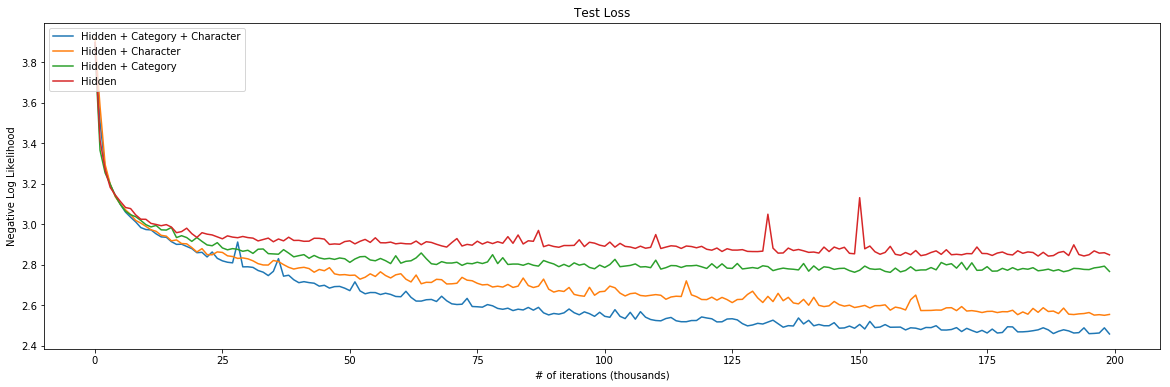

In [16]:
plt.figure(figsize=(20, 6))

plt.plot(rnn_hcc_test_losses)
plt.plot(rnn_hc_test_losses)
plt.plot(rnn_ch_test_losses)
plt.plot(rnn_h_test_losses)

plt.xlabel('# of iterations (thousands)')
plt.ylabel('Negative Log Likelihood')
plt.title('Test Loss')

plt.legend(['Hidden + Category + Character', 'Hidden + Character', 'Hidden + Category', 'Hidden'], loc='upper left')

plt.show()

## Discussion

The RNN that is fed the hidden state, the category, and the previous character at every step reduces the loss the most on the test set. This RNN has access to the category at every step and does not need to embed the category into the hidden state. It also has access to the previous character at every step so it also alleviates the need for the network to embed this information into the previous state. The hidden layers can focus on learning complex relations between state, the previous character, and the category. 

The second best performing RNN is the one that is fed the hidden state and the category at each step. The third best performing RNN is the one that is fed the hidden state and the previous character at each step. As we can see, removing the category from the input hurts the negative log likelihood loss more. This shows that the category is a more important feature to feed at every step than the previous character. This is because the hidden state is prone to forgetting the category that is only fed at the very first step, but is not prone to forgetting the previous character which is fed into the network at just the last step. The hidden state can capture the information we lose from not having the previous character, better than its ability to capture the information we lose from not having the category at each time step.

The worst performing RNN is the one that is just given the hidden state. This is because now the hidden state will be responsible for encoding the context of previous character(s) and to hold information about the category. The fixed length hidden state is responsible for more tasks and retaining more context so it performs the poorest on the test loss from all the RNN's we have considered.

